**NAME** - _Padmanavan Kumar_

**Anomaly Detection in Network Traffic**

Using unsupervised learning techniques such as _isolation forests_ or _autoencoders_ to detect unusual patterns or anomalies in network traffic data, which could indicate potential security breaches or system malfunctions.

Resources :

https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8920 - val_loss: 0.6623
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6158 - val_loss: 0.6058
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5852 - val_loss: 0.5931
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5814 - val_loss: 0.5876
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6578 - val_loss: 0.5844
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6330 - val_loss: 0.5827
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5401 - val_loss: 0.5813
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7004 - val_loss: 0.5804
Epoch 9/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6162 - val_loss: 0.5796
Epoch 10/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6226 - val_loss: 0.5790
Epoch 11/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6468 - val_loss: 0.5785
Epoch 12/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

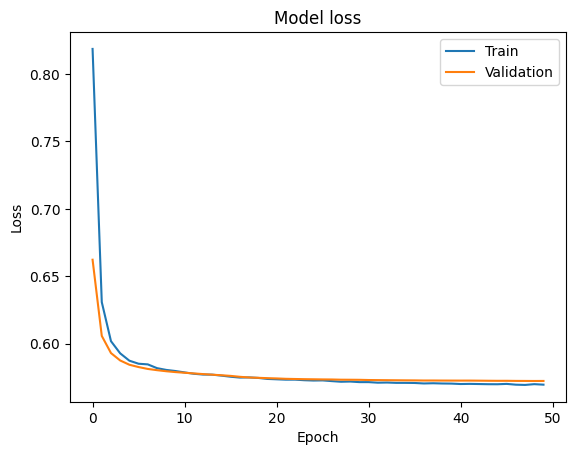

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


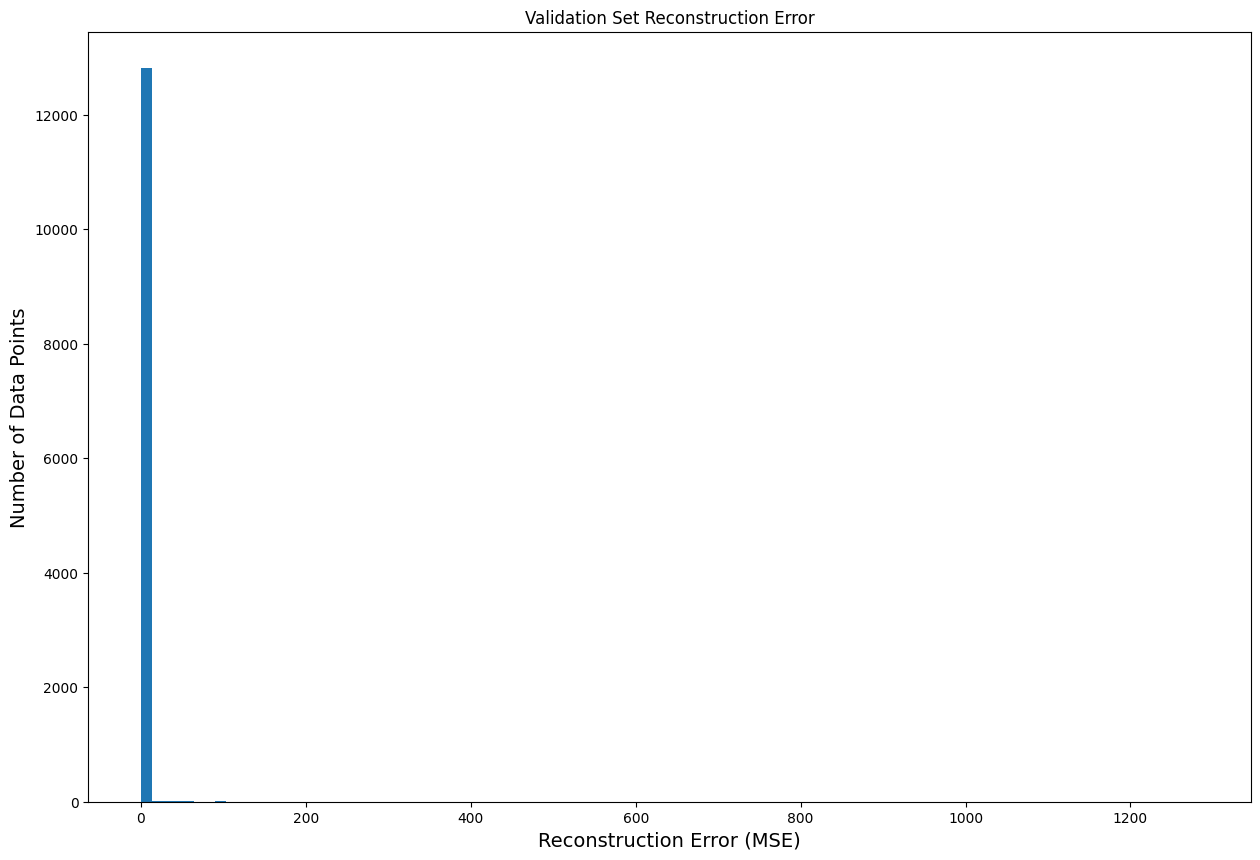

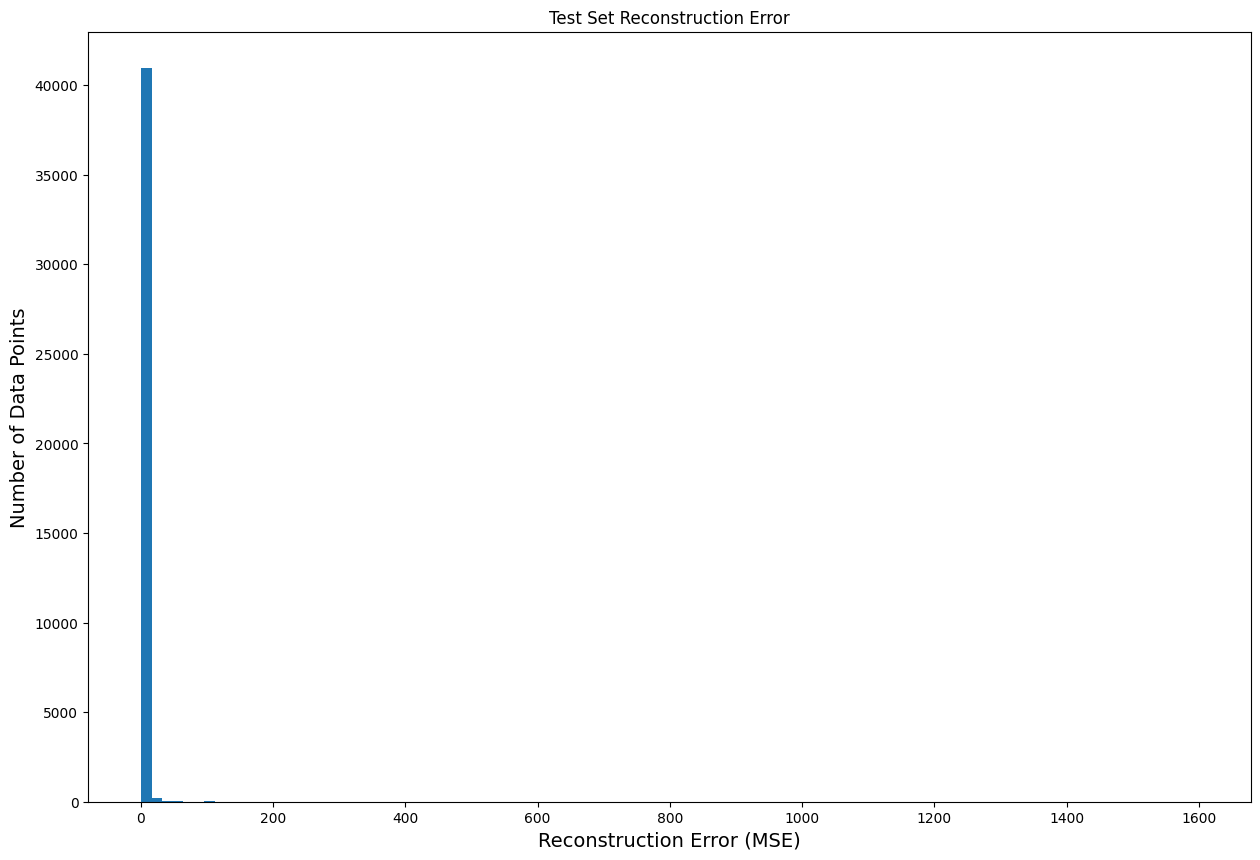

Reconstruction error threshold: 1.5052535518314594
Validation AUC: 35.33%
Test AUC: 27.12%


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

df = pd.read_csv('kddcup.data_10_percent_corrected', header=None, names=column_names)
df_test = pd.read_csv('corrected', header=None, names=column_names)

# Filter data to only include HTTP service and drop the service column
df = df[df["service"] == "http"].drop("service", axis=1)
df_test = df_test[df_test["service"] == "http"].drop("service", axis=1)

# Combine training and test data for label encoding
combined_data = pd.concat([df, df_test], axis=0)

# Encode categorical variables
label_encoders = {}
for col in combined_data.columns:
    if combined_data[col].dtype == 'object':
        le = LabelEncoder()
        combined_data[col] = le.fit_transform(combined_data[col])
        df[col] = le.transform(df[col])
        df_test[col] = le.transform(df_test[col])
        label_encoders[col] = le

# Shuffle and split data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

x_train = df_train.drop("label", axis=1)
y_train = df_train["label"]
x_val = df_val.drop("label", axis=1)
y_val = df_val["label"]
x_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Build the Autoencoder model
input_dim = x_train.shape[1]
encoding_dim = 14  # This can be adjusted based on your data

autoencoder = Sequential([
    Dense(encoding_dim, activation="relu", input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = autoencoder.fit(
    x_train, x_train, 
    epochs=50, 
    batch_size=256, 
    shuffle=True, 
    validation_data=(x_val, x_val),
    verbose=1
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate reconstruction error
reconstructions_val = autoencoder.predict(x_val)
mse_val = np.mean(np.power(x_val - reconstructions_val, 2), axis=1)

reconstructions_test = autoencoder.predict(x_test)
mse_test = np.mean(np.power(x_test - reconstructions_test, 2), axis=1)

# Plot histograms of reconstruction errors
def plot_histogram(mse, title):
    plt.figure(figsize=(15, 10))
    plt.hist(mse, bins=100)
    plt.xlabel('Reconstruction Error (MSE)', fontsize=14)
    plt.ylabel('Number of Data Points', fontsize=14)
    plt.title(title)
    plt.show()

plot_histogram(mse_val, 'Validation Set Reconstruction Error')
plot_histogram(mse_test, 'Test Set Reconstruction Error')

# Determine threshold based on validation set
threshold = np.percentile(mse_val, 95)
print(f"Reconstruction error threshold: {threshold}")

# Calculate AUC for Validation and Test Set
anomalies_val = mse_val > threshold
auc_val = roc_auc_score(y_val == label_encoders["label"].transform(["normal."])[0], anomalies_val)
print(f"Validation AUC: {auc_val:.2%}")

anomalies_test = mse_test > threshold
auc_test = roc_auc_score(y_test == label_encoders["label"].transform(["normal."])[0], anomalies_test)
print(f"Test AUC: {auc_test:.2%}")
